# Compare the motifs (the CWMs and hCWMs) and motif instance calls between the two fragment-length tasks in CUT&RUN
## How do the motif instance calls differ? Compare the distribution of the motif instance calls and see if there's a difference that can be explained by:
* Overlap with DNase-seq peaks
* Overlap with ATAC-seq peaks
* Correlation with ATAC-seq fragment lengths
* Overlap with H3K27ac or H3K4me3 (histone marks)

In [1]:
import os
os.chdir('/home/katie/bp_repo/reports/')

from util import import_shap_scores, import_peak_table
from util import trim_motif_by_ic
from util import figure_to_vdom_image
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from IPython.display import display
import tqdm
tqdm.tqdm_notebook()

plt.rcParams['figure.dpi'] = 130

/tmp/ipykernel_113851/1313173272.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm.tqdm_notebook()


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

In [3]:
# CTCF multi-task cutnrun motif hits

# Define parameters/fetch arguments
motif_hits_path_max = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
print("SHORT Motif hits path: %s" % motif_hits_path_max)

motif_hits_path_min = ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed']
print("LONG Motif hits path: %s" % motif_hits_path_min)

SHORT Motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed']
LONG Motif hits path: ['/home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed']


In [4]:
# Load in assay peaks
assay_bed_paths = ['/home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz',
                   '/home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz']
print("ATAC peaks path: %s" % assay_bed_paths[0])
print("DNASE peaks path: %s" % assay_bed_paths[1])
print("ac histone marks: %s" % assay_bed_paths[2])
print("me3 histone marks: %s" % assay_bed_paths[3])

ATAC peaks path: /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz
DNASE peaks path: /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz
ac histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz
me3 histone marks: /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz


In [5]:
# Import motif hits
hits_max = import_peak_table(motif_hits_path_max)          # 99,871 hits and peak lengths are 9, 10, or 25
hits_min = import_peak_table(motif_hits_path_min)          # 102,434 hits and peak lengths are 9

# Isolate to core motif
core_hits_max = hits_max[hits_max.name == '0_0']           # 92,566 hits and peak lengths are 9 only
core_hits_min = hits_min[hits_min.name == '0_0']           # 102,434 hits and peak lengths are 9

# Import assay peaks
atac_peak_table = import_peak_table([assay_bed_paths[0]])  # 278,564 peaks and TONS of peak lengths
dnase_peak_table = import_peak_table([assay_bed_paths[1]]) # 143,283 peaks and TONS of peak lengths
ac_peak_table = import_peak_table([assay_bed_paths[2]])    # 129,753 peaks and TONS of peak lengths
me3_peak_table = import_peak_table([assay_bed_paths[3]])   # 27,884 peaks and TONS of peak lengths

### DNase-seq overlap

In [6]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_dnase_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/DNase-peaks/ENCFF128ZVL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_dnase_overlap')

max_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_dnase_overlap',  # 69,959 overlaps
                                sep='\t', header=None)
min_dnase_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_dnase_overlap',  # 66,091 overlaps
                                sep='\t', header=None)

In [7]:
core_max_dnase_overlap = max_dnase_overlap[max_dnase_overlap.iloc[:,3] == '0_0']                # 64,193 core overlaps
core_min_dnase_overlap = min_dnase_overlap[min_dnase_overlap.iloc[:,3] == '0_0']                # 66,091 core overlaps

In [8]:
len(core_max_dnase_overlap) / len(core_hits_max)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF
# and i did check, core_max_dnase_overlap is a SUBSET of the original df, core_hits_max (check using merge function)

0.6939486878879549

In [9]:
len(core_min_dnase_overlap) / len(core_hits_min)  # % of min task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.6804950623140282

### ATAC-seq overlap

In [10]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_atac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/ATAC-peaks/ENCFF899OMR.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_atac_overlap')

max_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_atac_overlap',  # 78,914 overlaps
                                sep='\t', header=None)
min_atac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_atac_overlap',  # 80,048 overlaps
                                sep='\t', header=None)

In [11]:
core_max_atac_overlap = max_atac_overlap[max_atac_overlap.iloc[:,3] == '0_0']                # 72,915 core overlaps
core_min_atac_overlap = min_atac_overlap[min_atac_overlap.iloc[:,3] == '0_0']                # 80,048 core overlaps

In [12]:
len(core_max_atac_overlap) / len(core_hits_max)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.8530141417101944

In [13]:
len(core_min_atac_overlap) / len(core_hits_min)  # % of min task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.8284013972141964

#### ATAC-seq fragment length correlation

In [14]:
# TODO
# ...but also idk what todo smh send help

### H3K27ac overlap

In [15]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k27ac_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K27ac-histone-marks/ENCFF747IZX.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_h3k27ac_overlap')

max_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k27ac_overlap',  # 55,944 overlaps
                                sep='\t', header=None)
min_ac_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_h3k27ac_overlap',  # 59,861 overlaps
                                sep='\t', header=None)

In [16]:
core_max_ac_overlap = max_ac_overlap[max_ac_overlap.iloc[:,3] == '0_0']                # 51,600 core overlaps
core_min_ac_overlap = min_ac_overlap[min_ac_overlap.iloc[:,3] == '0_0']                # 59,861 core overlaps

In [17]:
len(core_max_ac_overlap) / len(core_hits_max)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.3123318643819413

In [18]:
len(core_min_ac_overlap) / len(core_hits_min)  # % of min task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.2977187459571348

### H3K4me3 overlap

In [19]:
# this only needs to be run once and saved then opened in the future as TSVs
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_maxfl120_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k4me3_overlap')
# os.system('bedtools intersect -u -a /home/katie/bp_repo/reports/tfm_hits/CTCF/ctcf_minfl150_feb7/tfm_matches.bed -b /home/katie/bp_repo/research/data/other-assays/A549/H3K4me3-histone-marks/ENCFF535EYL.bed.gz > /home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_h3k4me3_overlap')

max_me_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/max_motif_hits_h3k4me3_overlap',  # 10,917 overlaps
                                sep='\t', header=None)
min_me_overlap = pd.read_csv('/home/katie/bp_repo/reports/katie_notebooks/TASK_2/CTCF/min_motif_hits_h3k4me3_overlap',  # 14,213 overlaps
                                sep='\t', header=None)

In [20]:
core_max_me_overlap = max_me_overlap[max_me_overlap.iloc[:,3] == '0_0']                # 9,455 core overlaps
core_min_me_overlap = min_me_overlap[min_me_overlap.iloc[:,3] == '0_0']                # 14,213 core overlaps

In [21]:
len(core_max_me_overlap) / len(core_hits_max)  # % of max task hits overlapping >0 DNase peak ONLY FOR CORE MOTIF

0.17683941674604586

In [22]:
len(core_min_me_overlap) / len(core_hits_min)  # % of min task hits overlatacg >0 DNase peak ONLY FOR CORE MOTIF

0.16946828237526412

## Graphing

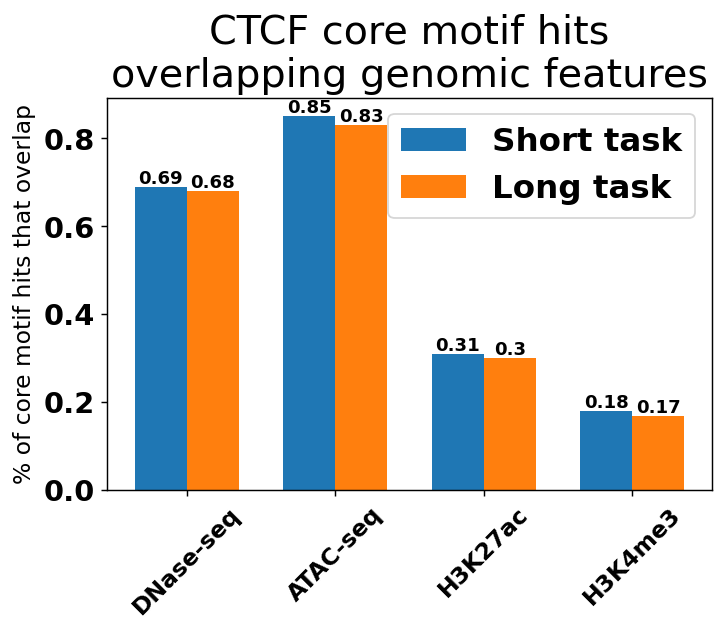

In [23]:
# order: ( % of short motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of long motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
short_stats = (len(core_max_dnase_overlap) / len(core_hits_max),
                 len(core_max_atac_overlap) / len(core_hits_max),
                 len(core_max_ac_overlap) / len(core_hits_max),
                 len(core_max_me_overlap) / len(core_hits_max))
long_stats = (len(core_min_dnase_overlap) / len(core_hits_min),
              len(core_min_atac_overlap) / len(core_hits_min),
              len(core_min_ac_overlap) / len(core_hits_min),
              len(core_min_me_overlap) / len(core_hits_min))

short_stats = [round(stat, 2) for stat in short_stats]
long_stats = [round(stat, 2) for stat in long_stats]

ind = np.arange(len(short_stats))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=130)
rects1 = ax.bar(ind - width/2, short_stats, width, 
                label='Short task')
rects2 = ax.bar(ind + width/2, long_stats, width,
                label='Long task')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of core motif hits that overlap', fontsize=13)
ax.set_title('CTCF core motif hits\noverlapping genomic features')
ax.set_xticks(ind)
ax.set_xticklabels(('DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")

plt.show()

## Extra nice combined version with cutnrun/chipseq

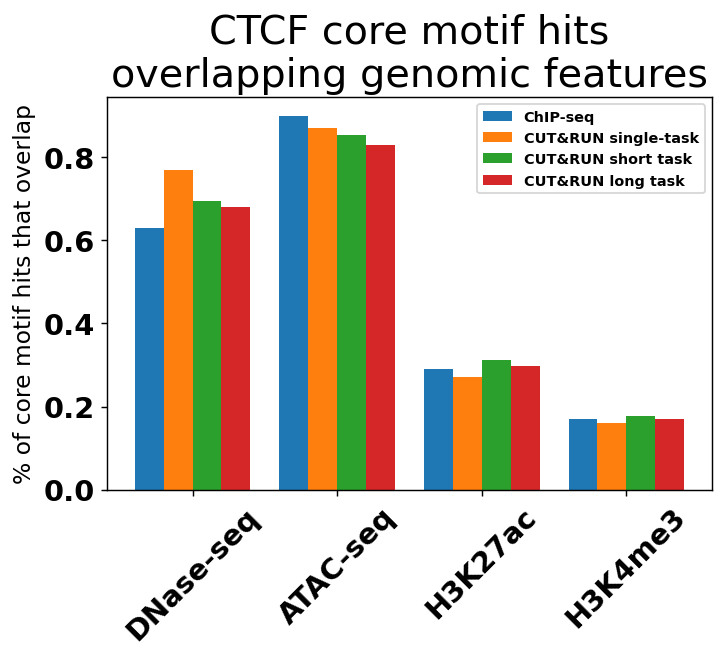

In [52]:
X = ['DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3']
chips = chipseq_stats = (0.63, 0.90, 0.29, 0.17)
cuts = (0.77, 0.87, 0.27, 0.16)
shorts = (len(core_max_dnase_overlap) / len(core_hits_max),
                 len(core_max_atac_overlap) / len(core_hits_max),
                 len(core_max_ac_overlap) / len(core_hits_max),
                 len(core_max_me_overlap) / len(core_hits_max))
longs = (len(core_min_dnase_overlap) / len(core_hits_min),
              len(core_min_atac_overlap) / len(core_hits_min),
              len(core_min_ac_overlap) / len(core_hits_min),
              len(core_min_me_overlap) / len(core_hits_min)) 
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.3, chips, 0.2, label = 'ChIP-seq')
plt.bar(X_axis - 0.1, cuts, 0.2, label = 'CUT&RUN single-task')
plt.bar(X_axis + 0.1, shorts, 0.2, label = 'CUT&RUN short task')
plt.bar(X_axis + 0.3, longs, 0.2, label = 'CUT&RUN long task')
  
plt.xticks(X_axis, X, rotation=45)
plt.ylabel("% of core motif hits that overlap", fontsize=13)
plt.title("CTCF core motif hits\noverlapping genomic features")
plt.legend(fontsize=8)
plt.show()

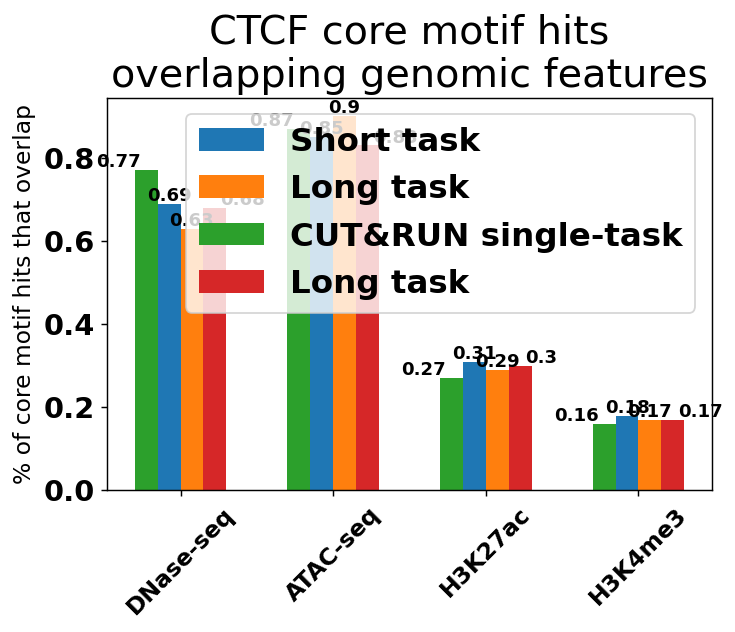

In [48]:
# order: ( % of short motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of chipseq motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
#          % of CUT&RUN motif hits overlapping assay, with assay order DNASE; ATAC; ac; me, 
#          % of long motif hits overlapping assay, with assay order DNASE; ATAC; ac; me)
short_stats = (len(core_max_dnase_overlap) / len(core_hits_max),
                 len(core_max_atac_overlap) / len(core_hits_max),
                 len(core_max_ac_overlap) / len(core_hits_max),
                 len(core_max_me_overlap) / len(core_hits_max))
long_stats = (len(core_min_dnase_overlap) / len(core_hits_min),
              len(core_min_atac_overlap) / len(core_hits_min),
              len(core_min_ac_overlap) / len(core_hits_min),
              len(core_min_me_overlap) / len(core_hits_min))
chipseq_stats = (0.63, 0.90, 0.29, 0.17)
cutnrun_stats = (0.77, 0.87, 0.27, 0.16)

short_stats = [round(stat, 2) for stat in short_stats]
long_stats = [round(stat, 2) for stat in long_stats]

ind = np.arange(len(short_stats))  # the x locations for the groups
width = 0.15  # the width of the bars

fig, ax = plt.subplots(dpi=130)
rects1 = ax.bar(ind - width/2, short_stats, width, 
                label='Short task')
rects2 = ax.bar(ind + width/2, chipseq_stats, width,
                label='Long task')
rects3 = ax.bar(ind - 1.5*width, cutnrun_stats, width, 
                label='CUT&RUN single-task')
rects4 = ax.bar(ind + 1.5*width, long_stats, width,
                label='Long task')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of core motif hits that overlap', fontsize=13)
ax.set_title('CTCF core motif hits\noverlapping genomic features')
ax.set_xticks(ind)
ax.set_xticklabels(('DNase-seq', 'ATAC-seq', 'H3K27ac', 'H3K4me3'), rotation=45, fontsize=13)
ax.legend(loc='upper right')

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(offset[xpos]*3, -0.5),  # use -0.5 point offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')


autolabel(rects1, "center")
autolabel(rects2, "center")
autolabel(rects3, "left")
autolabel(rects4, "right")

plt.show()